## Exploration of Dna2Vec embedding space for bacterial genomes; 11-mers



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../mylib/")

from genomic import sequence
from genomic.sequence import regex_filter, count_filter
from functools import partial
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import plotly.plotly as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D

ModuleNotFoundError: No module named 'genomic'

In [3]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190614-1532-k11to11-100d-10c-4870Mbp-sliding-X6c.w2v') 

In [27]:
from collections import Counter
def to_color(d):
    return 0. if "A" not in d.keys() else d["A"]/10.,   0. if "G" not in d.keys() else d["G"]/10., 0. if "C" not in d.keys() else d["C"]/10., 0.1 if "T" not in d.keys() else d["T"]/9.
kmers=list(word_vectors.wv.vocab.keys())[::1000]
X=word_vectors[kmers]
counts = [Counter(k) for k in kmers]
colors = [to_color(d) for d in counts]
X.shape

(4195, 100)

In [30]:
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
%time X_tsne = tsne.fit_transform(X)

CPU times: user 5min 5s, sys: 335 ms, total: 5min 5s
Wall time: 5min 5s


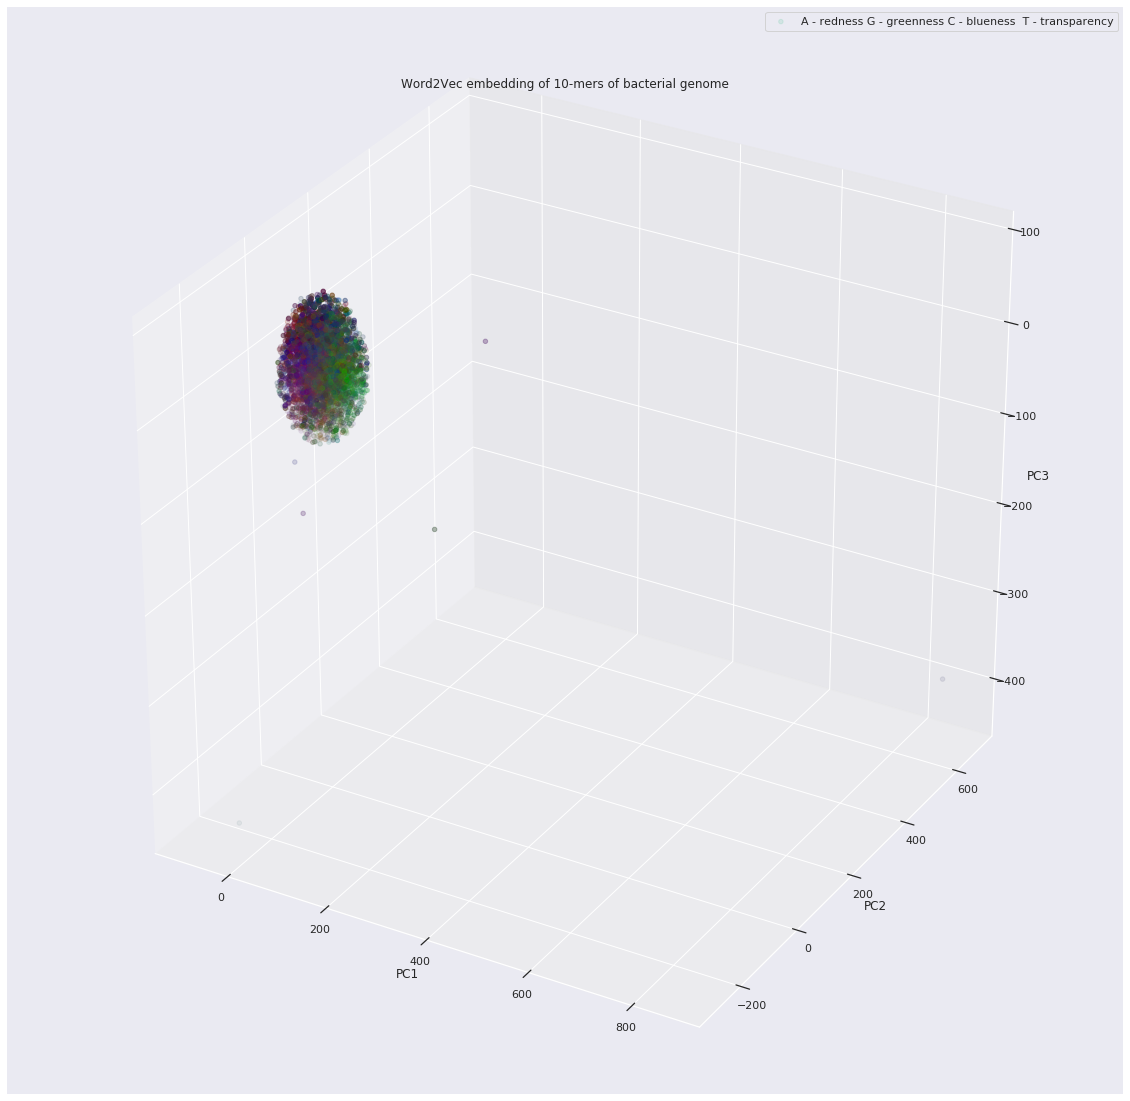

In [34]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_tsne[:,0],X_tsne[:,1],X_tsne[:,2],marker=".", c=colors,s=80)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("Word2Vec embedding of 10-mers of bacterial genome")
ax.legend(['A - redness G - greenness C - blueness  T - transparency'])
plt.show()

### Load Data

In [15]:
filters=[partial(regex_filter, rx="Streptomyces|Bacillus|Vibrio|Streptococcus|Rhizobium|Staphylococcus"),partial(regex_filter, rx="plasmid", keep=False)]
data = sequence.Dna2VecList.from_folder("/data/genomes/GenSeq_fastas",filters=filters,agg=partial(np.mean, axis=0),n_cpus=7,emb=word_vectors)
processors = [
    sequence.GSFileProcessor(),
    sequence.GSTokenizeProcessor(tokenizer=sequence.GSTokenizer(ngram=11, skip=0, n_cpus=7)),
    sequence.Dna2VecProcessor(emb=word_vectors)]
for p in processors:
    print("\n", type(p))
    %time p.process(data)


 <class 'genomic.sequence.GSFileProcessor'>
CPU times: user 1.09 s, sys: 313 ms, total: 1.4 s
Wall time: 2.01 s

 <class 'genomic.sequence.GSTokenizeProcessor'>
CPU times: user 5.76 s, sys: 314 ms, total: 6.08 s
Wall time: 6.94 s

 <class 'genomic.sequence.Dna2VecProcessor'>
CPU times: user 1min 2s, sys: 49.3 s, total: 1min 51s
Wall time: 3min 11s


In [16]:
data

Dna2VecList 3687 with itmes, 8-mer tokensation
 Word2Vec(vocab=4194293, size=100, alpha=0.025), reducer:functools.partial(<function mean at 0x7f7b3efdd7b8>, axis=0)
 Head: 
  NZ_FQXZ01000077.1 Vibrio aerogenes CECT 7868, whole genome shotgun sequence
  [ 63.322296  -1.018698  -8.466168 -68.06348  ... -41.492264 -38.949818   9.52057  -68.813675]
 Tail: 
  NZ_FMTM01000022.1 Rhizobium loessense strain CGMCC 1.3401, whole genome shotgun sequence
  [ 2036.6025   549.3116  -318.6594 -3079.0918 ... -1582.4526 -1833.6526   615.8259 -3099.5613]

### Create Dendrogram

In [17]:
def log_scale(X):
    x=np.asarray(X);e=1e-6
    return np.log10(x+np.abs(x.min())+e) 


x=np.asarray(data.items)
bad_fastas = np.where(np.mean(x,axis=1) == 0.)[0]
X = np.delete(x, bad_fastas,0)
labelList=[" ".join(i.split()[1:3]) for i in data.descriptions]
labelList=np.delete(np.asarray(labelList), bad_fastas)
y=labelList

X_df=pd.DataFrame(data=X, index=labelList)

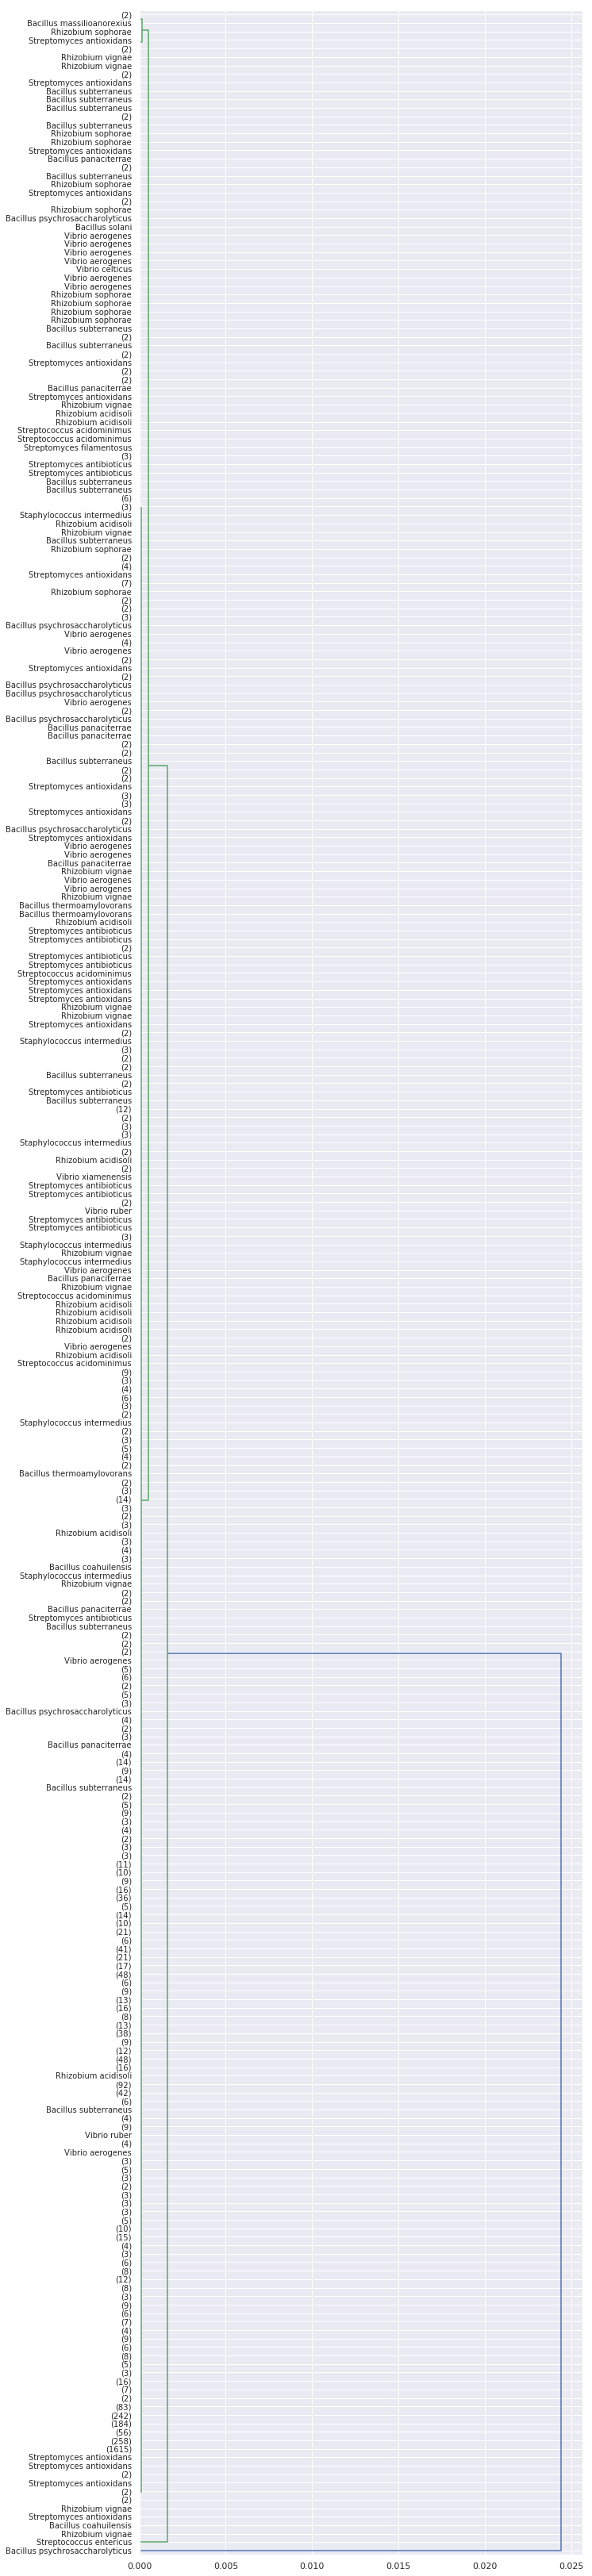

In [18]:
linked = linkage(log_scale(X),method="complete", metric="cosine")

fig=plt.figure(figsize=(10, 59)) 
ax1 = fig.add_subplot(111)

htree = dendrogram(linked,  
            ax=ax1,
            orientation='right',
            p=300,
            truncate_mode='lastp',
            leaf_font_size = 10,
            labels=labelList,
            distance_sort='descending',
            show_contracted=True,       
            show_leaf_counts=True)

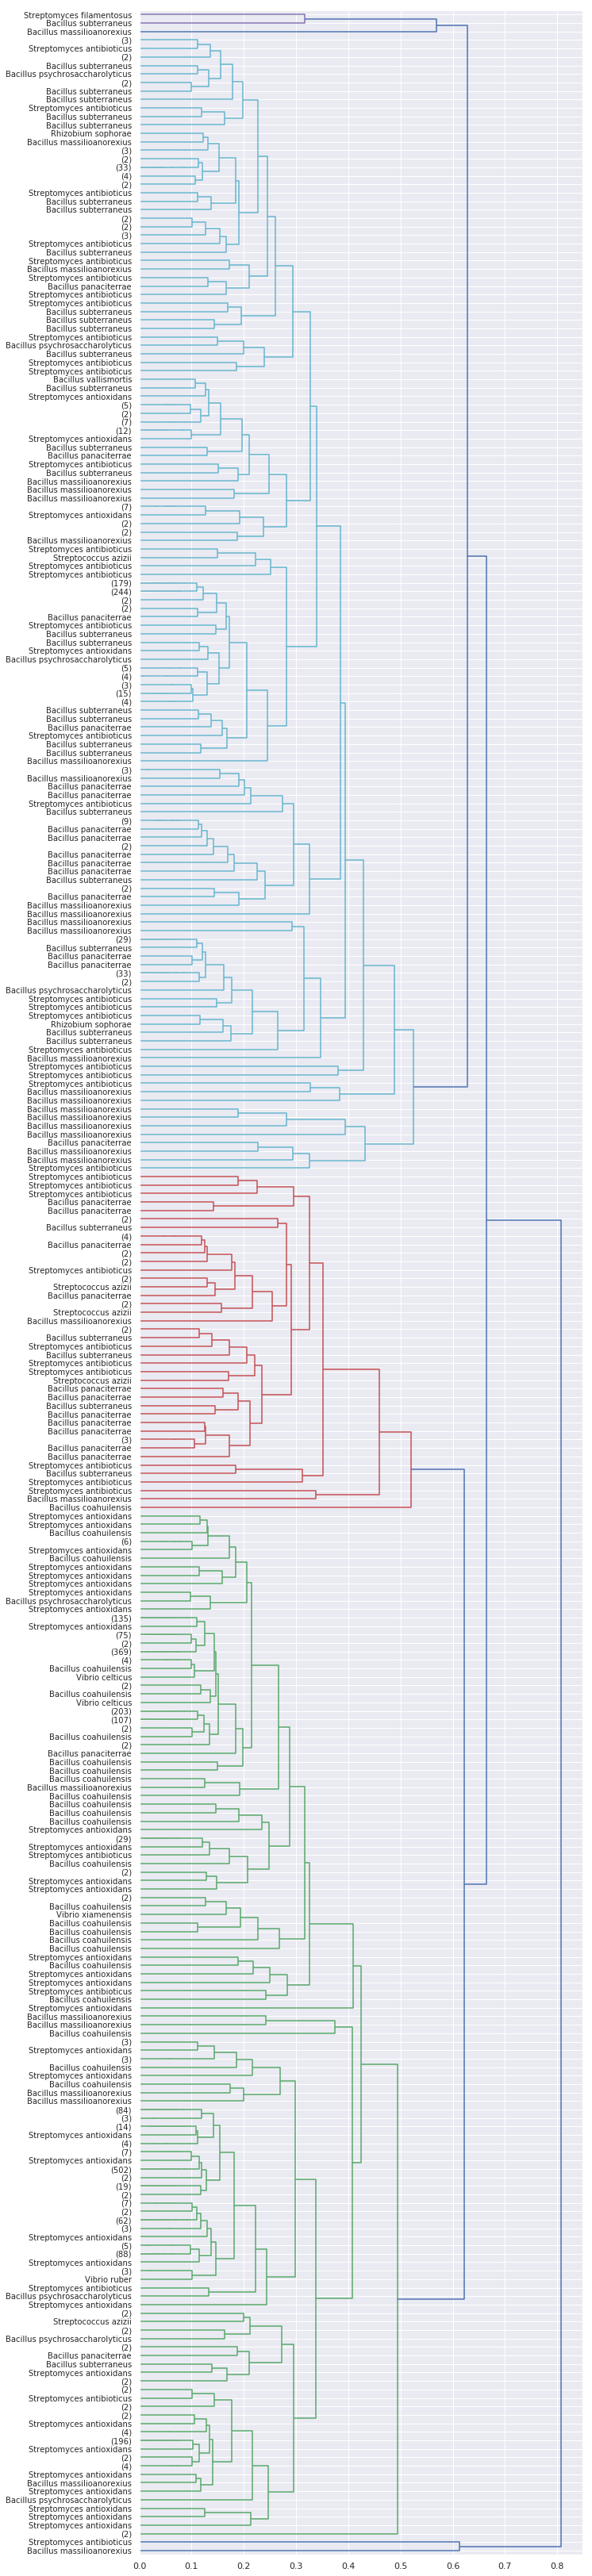

In [29]:
linked = linkage(X,method="complete", metric="correlation")

fig=plt.figure(figsize=(10, 59)) 
ax1 = fig.add_subplot(111)

htree = dendrogram(linked,  
            ax=ax1,
            orientation='right',
            p=300,
            truncate_mode='lastp',
            leaf_font_size = 10,
            labels=labelList,
            distance_sort='descending',
            show_contracted=True,       
            show_leaf_counts=True)

In [19]:
def log_scale(X):
    x=np.asarray(X);e=1e-6
    return np.log10(x+np.abs(x.min())+e) 


x=np.asarray(data.items)
bad_fastas = np.where(np.mean(x,axis=1) == 0.)[0]
X = np.delete(x, bad_fastas,0)
labelList=[" ".join(i.split()[1:3]) for i in data.descriptions]
labelList=np.delete(np.asarray(labelList), bad_fastas)
vocab=list(np.unique(labelList))
y=[vocab.index(x) for x in labelList]

In [20]:
tsne = manifold.TSNE(n_components=3, init='pca', perplexity=50, metric="correlation",random_state=0)
%time X3 = tsne.fit_transform(log_scale(X))

genus = [i.split()[0] for i in labelList]
genus_vocab=list(np.unique(genus))
y=[genus_vocab.index(x) for x in genus]
genus_vocab

X3_df = pd.DataFrame(data=X3, columns=["pc1",'pc2','pc3'], index=labelList)

X3_df["genus"]=genus
X3_df["y"]=y

genus_df=X3_df.groupby("genus").agg({"pc1": list, "pc2":list,"pc3":list,"y":np.mean})

CPU times: user 2min 21s, sys: 498 ms, total: 2min 22s
Wall time: 2min 21s


In [21]:
data=[]
for g in genus_df.index:
    trace  = go.Scatter3d(
        name = str(g),
        x=genus_df.loc[g,"pc1"],
        y=genus_df.loc[g,"pc2"],
        z=genus_df.loc[g,"pc3"],
        mode='markers',
        marker=dict(
            size=8,
            color=genus_df.loc[g,"y"],                # set color to an array/list of desired values
            colorscale='Jet',           # choose a colorscale
            opacity=0.5)
    )

    data.append(trace)
    

layout = go.Layout(
    width=1299,
    height=1299,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='correlation distance 11-mer embedding ncbi-genomes-2019-04-07')

/home/serge/.local/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [16]:
all_fastas = sequence.Dna2VecList.from_folder("/data/genomes/GenSeq_fastas/train").descriptions
inventory = pd.DataFrame(data=[l.split()[1:3] for l in all_fastas], columns=["genus","species" ]).groupby(["genus", "species"]).agg({"species": "count"})
inventory.columns=["count"]
inventory

count
genus            species                      
Bacillus         cereus                      2
                 coahuilensis              138
                 eiseniae                    9
                 krulwichiae                 1
                 mannanilyticus            108
                 massilioanorexius         120
                 panaciterrae              189
                 psychrosaccharolyticus    265
                 solani                     12
                 subterraneus              208
                 vallismortis               80
Clostridium      aceticum                    2
                 amylolyticum               20
                 butyricum                   2
                 chauvoei                    1
                 haemolyticum              234
Corynebacterium  accolens                   38
                 atypicum                    2
                 doosanense                  2
                 genitalium                  1
                 glucuronolyticum           41
                 imitans                     1
                 timonense                  18
Enterobacter     aerogenes                   1
Escherichia      albertii                    1
                 fergusonii                  2
                 marmotae                  130
Klebsiella       oxytoca                    12
                 quasipneumoniae             3
                 variicola                   1
...                                        ...
Shigella         boydii                      6
                 dysenteriae                 3
                 sonnei                      5
Staphylococcus   agnetis                     2
                 aureus                      1
                 hyicus                      1
                 intermedius               286
                 warneri                     9
                 xylosus                     2
Stenotrophomonas acidaminiphila              1
                 ginsengisoli               99
                 koreensis                  58
                 pavanii                    17
                 rhizophila                  1
Streptococcus    acidominimus              111
                 azizii                     43
                 entericus                  33
                 himalayensis                1
                 minor                      33
                 oralis                      1
Streptomyces     albidoflavus              115
                 ambofaciens                 2
                 antibioticus              343
                 antioxidans               282
                 filamentosus                1
Vibrio           aerogenes                  77
                 celticus                  196
                 europaeus                  10
                 ruber                     103
                 xiamenensis                82

[88 rows x 1 columns]

In [ ]:
counts = inventory.reset_index().groupby("genus").agg({"count", sum}).drop(("species"), axis=1)
counts.columns=["species","sequences"]

In [20]:
counts.sort_values("sequences", ascending=False)

,species,sequences
genus,,
Bacillus,11,1132
Streptomyces,5,743
Vibrio,5,468
Rhizobium,6,325
Pseudomonas,8,304
Staphylococcus,6,301
Clostridium,5,259
Streptococcus,6,222
Planktothrix,5,179


In [17]:
[i.split()[1:3] for i in all_fastas if  "plasmid" in i]

[['Staphylococcus', 'agnetis'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Klebsiella', 'oxytoca'],
 ['Vibrio', 'europaeus'],
 ['Vibrio', 'europaeus'],
 ['Staphylococcus', 'xylosus'],
 ['Staphylococcus', 'warneri'],
 ['Staphylococcus', 'warneri'],
 ['Staphylococcus', 'warneri'],
 ['Staphylococcus', 'warneri'],
 ['Staphylococcus', 'warneri'],
 ['Staphylococcus', 'warneri'],
 ['Staphylococcus', 'warneri'],
 ['Staphylococcus', 'warneri'],
 ['Corynebacterium', 'atypicum'],
 ['Rhizobium', 'leguminosarum'],
 ['Rhizobium', 'leguminosarum'],
 ['Rhizobium', 'leguminosarum'],
 ['Rhizobium', 'leguminosarum'],
 ['Rhizobium', 'leguminosarum'],
 ['Clostridium', 'aceticum'],
 ['Shigella', 'sonnei'],
 ['Shigella', 'sonnei'],
 ['Shigella', 'sonnei'],
 ['Shigella', 's

### New heading